In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS, RandomEffects
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
from linearmodels.panel import compare


In [2]:
df = pd.read_excel("Panel_Dataset_Final.xlsx")

In [3]:
df.head()

,Company,Year,Country_ISO_code,BvD_ID_number,"NACE_Rev._2,_core_code_(4_digits)",BvD_sectors,Cash_flow_/_Operating_revenue,Current_ratio,EBITDA_margin,Enterprise_value_/_EBITDA,...,total_debt,Board_size,Female_pct,Nationality_diversity,Education_diversity,Publication_Count,Granted_Publications,Publication_Progress,Research_Intensity,log_Publication_Count
0,APPLE INC.,2024,US,US942404110,2620,Computer Hardware,26.898,0.867,34.437,26.622,...,1.426939e+08,533.0,0.0,0.0,0.0,182951.0,80936.0,0.910324,231183.0,12.116979
1,ALPHABET INC.,2024,US,US611767919,6209,Media & Broadcasting,32.978,1.837,37.009,7.905,...,3.728388e+07,9573.0,0.0,0.0,0.0,193303.0,84399.0,0.916006,237969.0,12.172019
2,MICROSOFT CORPORATION,2024,US,US911144442,5829,"Industrial, Electric & Electronic Machinery",45.132,1.275,53.737,25.244,...,1.229974e+08,6485.0,0.0,1.0,0.0,289837.0,114280.0,0.947745,300211.0,12.577077
3,"SAMSUNG ELECTRONICS CO.,LTD.",2024,KR,KR1301110006246,2630,Communications,11.974,2.433,11.677,8.061,...,3.054364e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"META PLATFORMS, INC.",2024,US,US201665019,6209,Media & Broadcasting,47.332,2.978,51.836,14.403,...,5.989763e+07,2348.0,0.0,0.0,0.0,19753.0,7669.0,0.673133,25128.0,9.891111


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27240 entries, 0 to 27239
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Company                                 27240 non-null  object 
 1   Year                                    27240 non-null  int64  
 2   Country_ISO_code                        27240 non-null  object 
 3   BvD_ID_number                           27240 non-null  object 
 4   NACE_Rev._2,_core_code_(4_digits)       27240 non-null  int64  
 5   BvD_sectors                             27240 non-null  object 
 6   Cash_flow_/_Operating_revenue           27000 non-null  float64
 7   Current_ratio                           27195 non-null  float64
 8   EBITDA_margin                           27060 non-null  float64
 9   Enterprise_value_/_EBITDA               22575 non-null  float64
 10  Gearing                                 27040 non-null  fl

In [5]:
# Ensure company name is a clean string
df["Company"] = df["Company"].astype(str).str.strip()

# BvD_ID_number often should be string (avoid losing leading zeros)
df["BvD_ID_number"] = df["BvD_ID_number"].astype(str)

# Firm identifier – if you have a firm id, use that. If not, use company name + country.
df['firm_id'] = df['BvD_ID_number'].astype(str)

# Sort rows
df = df.sort_values(['firm_id', 'Year']).reset_index(drop=True)


In [6]:
df["NACE_Rev._2,_core_code_(4_digits)"] = df["NACE_Rev._2,_core_code_(4_digits)"].astype(str)

In [7]:
df = df.rename(columns={"NACE_Rev._2,_core_code_(4_digits)": "NACE_raw"})
df = df.rename(columns={"Solvency_ratio_(Asset_based)": "Solvency_ratio_asset"})

In [8]:
df.describe()

,Year,Cash_flow_/_Operating_revenue,Current_ratio,EBITDA_margin,Enterprise_value_/_EBITDA,Gearing,Market_cap_/_Cash_flow_from_operations,Number_of_employees,Operating_revenue_(Turnover)_th_USD,P/L_before_tax_th_USD,...,total_debt,Board_size,Female_pct,Nationality_diversity,Education_diversity,Publication_Count,Granted_Publications,Publication_Progress,Research_Intensity,log_Publication_Count
count,27240.00000,27000.000000,27195.000000,27060.000000,22575.000000,27040.000000,17995.000000,23530.000000,2.721000e+04,2.721000e+04,...,2.630400e+04,4980.000000,4980.000000,4980.000000,4980.000000,4555.000000,4270.000000,3890.000000,3960.000000,4555.000000
mean,2022.00000,10.921747,2.743113,14.126119,15.750198,67.911523,17.755667,6913.639184,2.525120e+06,3.323381e+05,...,1.965058e+06,242.376506,0.102410,0.191767,0.639558,8893.680571,4033.380562,2.509722,9385.853535,5.437558
std,1.41424,16.945789,3.475677,17.691560,16.185143,99.375055,18.421537,24049.925969,1.185625e+07,3.362557e+06,...,1.023567e+07,734.630852,0.303217,0.393730,0.480177,46379.400935,19673.761634,7.032763,42401.422055,2.854649
min,2020.00000,-88.372000,0.020000,-97.373000,-94.304000,0.000000,0.020000,2.000000,4.769728e+01,-1.121000e+07,...,0.000000e+00,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.033333,2.000000,0.693147
25%,2021.00000,4.545000,1.220000,6.030250,6.200000,10.034500,5.829000,449.000000,6.921980e+04,3.445608e+02,...,8.628017e+03,13.000000,0.000000,0.000000,0.000000,21.000000,12.000000,0.837972,45.000000,3.091042
50%,2022.00000,10.449000,1.813000,12.814000,10.740000,34.903500,11.526000,1327.000000,2.475265e+05,1.266340e+04,...,5.691759e+04,22.500000,0.000000,0.000000,1.000000,186.000000,105.000000,1.297496,292.500000,5.231109
75%,2023.00000,18.242500,2.969000,21.713750,19.186000,82.961250,22.795000,4311.000000,1.035637e+06,7.941200e+04,...,3.681315e+05,76.250000,0.000000,0.000000,1.000000,1989.000000,969.000000,2.125000,2857.250000,7.595890
max,2024.00000,96.334000,75.786000,93.370000,99.807000,985.093000,99.645000,774000.000000,3.910350e+08,1.234850e+08,...,3.049248e+08,9573.000000,1.000000,1.000000,1.000000,709582.000000,310051.000000,157.333333,558472.000000,13.472433


In [9]:
missing_summary = df.isna().sum().sort_values(ascending=False).to_frame("n_missing")
missing_summary["pct_missing"] = (df.isna().mean() * 100).sort_values(ascending=False)
missing_summary

,n_missing,pct_missing
Publication_Progress,23350,85.719530
Research_Intensity,23280,85.462555
Granted_Publications,22970,84.324523
log_Publication_Count,22685,83.278267
Publication_Count,22685,83.278267
Nationality_diversity,22260,81.718062
Female_pct,22260,81.718062
Board_size,22260,81.718062
Education_diversity,22260,81.718062
Tobins_Q,10615,38.968429


In [10]:
core_vars = [
    "firm_id",
    "Year",
    # Independent variables
    "Female_pct",
    "Nationality_diversity",
    "Education_diversity",
    # Dependent variables
    "ROA_using_Net_income",
    "Tobins_Q",
    "Publication_Count"
]


In [11]:
print(df.columns.tolist())


['Company', 'Year', 'Country_ISO_code', 'BvD_ID_number', 'NACE_raw', 'BvD_sectors', 'Cash_flow_/_Operating_revenue', 'Current_ratio', 'EBITDA_margin', 'Enterprise_value_/_EBITDA', 'Gearing', 'Market_cap_/_Cash_flow_from_operations', 'Number_of_employees', 'Operating_revenue_(Turnover)_th_USD', 'P/L_before_tax_th_USD', 'Profit_margin', 'R&D_expenses_/_Operating_revenue', 'ROA_using_Net_income', 'ROE_using_P/L_before_tax', 'Shareholders_funds_th_USD', 'Solvency_ratio_asset', 'Total_assets_th_USD', 'Tobins_Q', 'leverage', 'log_assets', 'total_debt', 'Board_size', 'Female_pct', 'Nationality_diversity', 'Education_diversity', 'Publication_Count', 'Granted_Publications', 'Publication_Progress', 'Research_Intensity', 'log_Publication_Count', 'firm_id']


In [12]:
df = df.dropna(subset=core_vars).copy()
print("After core variable filtering:", df.shape)

After core variable filtering: (2238, 36)


In [13]:
controls = [
    "Board_size",
    "Total_assets_th_USD",
    "Number_of_employees",
    "leverage",
    "Profit_margin",
    "EBITDA_margin",
    "Solvency_ratio_(Asset_based)",
    "RD_expenses_Operating_revenue",
    "Operating_revenue_(Turnover)_ths_USD"
]

controls = [c for c in controls if c in df.columns]
print("Controls used:", controls)


Controls used: ['Board_size', 'Total_assets_th_USD', 'Number_of_employees', 'leverage', 'Profit_margin', 'EBITDA_margin']


In [14]:
industry_col = "NACE_raw"

for col in controls:
    df[col] = df.groupby([industry_col, "Year"])[col].transform(lambda x: x.fillna(x.median()))
    df[col] = df[col].fillna(df[col].median())

print("Missing remaining in controls?", df[controls].isnull().any().any())


Missing remaining in controls? False


In [15]:
winsor_cols = [
    "Female_pct", "Nationality_diversity", "Education_diversity",
    "ROA_using_Net_income", "Tobins_Q", "Publication_Count"
] + controls

winsor_cols = [c for c in winsor_cols if c in df.columns]

def winsor(s, lo=0.01, hi=0.99):
    return s.clip(lower=s.quantile(lo), upper=s.quantile(hi))

for col in winsor_cols:
    df[col] = winsor(df[col])

print("Winsorisation done on:", winsor_cols)


Winsorisation done on: ['Female_pct', 'Nationality_diversity', 'Education_diversity', 'ROA_using_Net_income', 'Tobins_Q', 'Publication_Count', 'Board_size', 'Total_assets_th_USD', 'Number_of_employees', 'leverage', 'Profit_margin', 'EBITDA_margin']


In [16]:
df["ln_Publication_Count"] = np.log1p(df["Publication_Count"])

In [17]:
# Create log-transformed controls
df['log_assets'] = np.log(df['Total_assets_th_USD'] + 1)

# Only create log_employees if Number_of_employees exists
if 'Number_of_employees' in df.columns:
    df['log_employees'] = np.log(df['Number_of_employees'] + 1)

# Sort and set panel index
df = df.sort_values(['firm_id', 'Year'])
df = df.set_index(['firm_id', 'Year'])

df.head()


Company Country_ISO_code BvD_ID_number NACE_raw  \
firm_id      Year                                                              
AT9010000310 2020  ZUMTOBEL GROUP AG               AT  AT9010000310     2740   
             2021  ZUMTOBEL GROUP AG               AT  AT9010000310     2740   
             2022  ZUMTOBEL GROUP AG               AT  AT9010000310     2740   
             2023  ZUMTOBEL GROUP AG               AT  AT9010000310     2740   
             2024  ZUMTOBEL GROUP AG               AT  AT9010000310     2740   

                                                   BvD_sectors  \
firm_id      Year                                                
AT9010000310 2020  Industrial, Electric & Electronic Machinery   
             2021  Industrial, Electric & Electronic Machinery   
             2022  Industrial, Electric & Electronic Machinery   
             2023  Industrial, Electric & Electronic Machinery   
             2024  Industrial, Electric & Electronic Machinery   

                   Cash_flow_/_Operating_revenue  Current_ratio  \
firm_id      Year                                                 
AT9010000310 2020                          7.165          1.166   
             2021                          7.165          1.166   
             2022                          7.165          1.166   
             2023                          7.165          1.166   
             2024                          7.165          1.166   

                   EBITDA_margin  Enterprise_value_/_EBITDA  Gearing  ...  \
firm_id      Year                                                     ...   
AT9010000310 2020          9.362                      3.159   61.699  ...   
             2021          9.362                      3.159   61.699  ...   
             2022          9.362                      3.159   61.699  ...   
             2023          9.362                      3.159   61.699  ...   
             2024          9.362                      3.159   61.699  ...   

                   Female_pct  Nationality_diversity  Education_diversity  \
firm_id      Year                                                           
AT9010000310 2020         1.0                    0.0                  1.0   
             2021         1.0                    0.0                  1.0   
             2022         1.0                    0.0                  1.0   
             2023         1.0                    0.0                  1.0   
             2024         1.0                    0.0                  1.0   

                   Publication_Count  Granted_Publications  \
firm_id      Year                                            
AT9010000310 2020            13451.0                7699.0   
             2021            13451.0                7699.0   
             2022            13451.0                7699.0   
             2023            13451.0                7699.0   
             2024            13451.0                7699.0   

                   Publication_Progress  Research_Intensity  \
firm_id      Year                                             
AT9010000310 2020              2.049787             15440.0   
             2021              2.049787             15440.0   
             2022              2.049787             15440.0   
             2023              2.049787             15440.0   
             2024              2.049787             15440.0   

                   log_Publication_Count  ln_Publication_Count  log_employees  
firm_id      Year                                                              
AT9010000310 2020               9.506883              9.506883       8.585039  
             2021               9.506883              9.506883       8.585039  
             2022               9.506883              9.506883       8.585039  
             2023               9.506883              9.506883       8.585039  
             2024               9.506883              9.506883       8.585039  

[5 rows x 36 colu

In [18]:
# Replace raw controls with log controls for modeling
controls_model = [c for c in controls if c not in ["Total_assets_th_USD", "Number_of_employees"]]
controls_model += [c for c in ["log_assets", "log_employees"] if c in df.columns]

print("Controls used in regressions:", controls_model)


Controls used in regressions: ['Board_size', 'leverage', 'Profit_margin', 'EBITDA_margin', 'log_assets', 'log_employees']


In [19]:
df.index.names

FrozenList(['firm_id', 'Year'])

In [20]:
# ----------------------------
# Variables for hypotheses
# ----------------------------
DV_H1 = "ROA_using_Net_income"
DV_H2 = "Tobins_Q"
DV_H3 = "ln_Publication_Count"   # use log innovation

IVS = ["Female_pct", "Nationality_diversity", "Education_diversity"]

# ONE final controls list used in regressions
controls_model = [
    "Board_size",
    "leverage",
    "Profit_margin",
    "EBITDA_margin",
    "Solvency_ratio_asset",
    "log_assets",
    "log_employees"
]

# Keep only existing columns
IVS = [c for c in IVS if c in df.columns]
controls_model = [c for c in controls_model if c in df.columns]

print("IVS:", IVS)
print("Controls used in regressions:", controls_model)

# Check missing columns (helpful debug)
needed = IVS + controls_model + [DV_H1, DV_H2, DV_H3]
missing = [c for c in needed if c not in df.columns]
print("Missing columns:", missing)


IVS: ['Female_pct', 'Nationality_diversity', 'Education_diversity']
Controls used in regressions: ['Board_size', 'leverage', 'Profit_margin', 'EBITDA_margin', 'Solvency_ratio_asset', 'log_assets', 'log_employees']
Missing columns: []



=== Descriptive statistics (key variables) ===


,count,mean,std,min,25%,50%,75%,max
ROA_using_Net_income,2238.0,3.978843,6.646262,-18.421790,0.887000,3.784000,7.214000,24.211000
Tobins_Q,2238.0,0.249884,0.154780,0.005339,0.119783,0.238862,0.360577,0.634848
ln_Publication_Count,2238.0,5.026325,2.720024,0.693147,2.847503,4.852030,7.006695,11.931794
Female_pct,2238.0,0.108579,0.311180,0.000000,0.000000,0.000000,0.000000,1.000000
Nationality_diversity,2238.0,0.047364,0.212463,0.000000,0.000000,0.000000,0.000000,1.000000
Education_diversity,2238.0,0.817694,0.386183,0.000000,1.000000,1.000000,1.000000,1.000000
Board_size,2238.0,24.264075,28.612036,5.000000,13.000000,18.000000,27.000000,243.000000
leverage,2238.0,0.249706,0.154914,0.004718,0.119480,0.238624,0.360551,0.634847
Profit_margin,2238.0,6.728636,11.282987,-33.765000,1.986000,6.757000,12.276000,42.572000
EBITDA_margin,2238.0,16.832880,12.346381,-7.793000,9.226000,14.750000,22.029000,61.685000



=== Correlation matrix (key variables) ===


,ROA_using_Net_income,Tobins_Q,ln_Publication_Count,Female_pct,Nationality_diversity,Education_diversity,Board_size,leverage,Profit_margin,EBITDA_margin,Solvency_ratio_asset,log_assets,log_employees
ROA_using_Net_income,1.000000,-0.202356,0.060136,0.116522,-0.033334,-0.048983,0.029194,-0.202409,0.829461,0.430967,0.274745,0.030558,0.027003
Tobins_Q,-0.202356,1.000000,0.213846,-0.018538,0.023270,-0.243338,0.206238,0.999987,-0.078627,0.253550,-0.617902,0.482556,0.421332
ln_Publication_Count,0.060136,0.213846,1.000000,0.089838,-0.060005,-0.418463,0.336803,0.214519,0.141313,0.142067,-0.068000,0.603329,0.534135
Female_pct,0.116522,-0.018538,0.089838,1.000000,0.010079,-0.125359,0.079923,-0.018290,0.100062,0.036648,0.003662,0.140956,0.144534
Nationality_diversity,-0.033334,0.023270,-0.060005,0.010079,1.000000,0.050802,-0.019928,0.023378,0.003653,-0.033617,-0.056396,-0.024916,0.003794
Education_diversity,-0.048983,-0.243338,-0.418463,-0.125359,0.050802,1.000000,-0.379860,-0.243609,-0.106630,-0.226131,0.087967,-0.546488,-0.479315
Board_size,0.029194,0.206238,0.336803,0.079923,-0.019928,-0.379860,1.000000,0.206529,0.067426,0.107791,-0.096216,0.435262,0.404376
leverage,-0.202409,0.999987,0.214519,-0.018290,0.023378,-0.243609,0.206529,1.000000,-0.078608,0.253399,-0.618082,0.483896,0.422639
Profit_margin,0.829461,-0.078627,0.141313,0.100062,0.003653,-0.106630,0.067426,-0.078608,1.000000,0.567969,0.202084,0.136197,0.092571
EBITDA_margin,0.430967,0.253550,0.142067,0.036648,-0.033617,-0.226131,0.107791,0.253399,0.567969,1.000000,0.103570,0.295743,0.097372


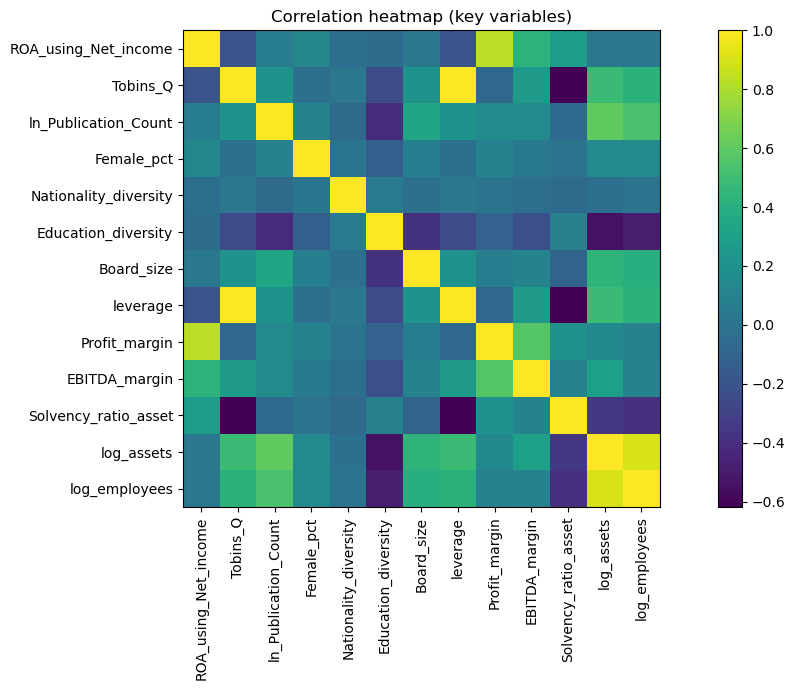

In [21]:
key_cols = [DV_H1, DV_H2, DV_H3] + IVS + controls_model
key_cols = [c for c in key_cols if c in df.columns]

desc = df[key_cols].describe().T
print("\n=== Descriptive statistics (key variables) ===")
display(desc)

print("\n=== Correlation matrix (key variables) ===")
corr = df[key_cols].corr(numeric_only=True)
display(corr)

plt.figure(figsize=(12, 7))
plt.imshow(corr.values)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.title("Correlation heatmap (key variables)")
plt.tight_layout()
plt.show()


In [22]:
# ============================================================
# 3) Multicollinearity diagnostics (VIF) (proposal robustness)
# ============================================================
def compute_vif(frame, cols):
    tmp = frame[cols].dropna().copy()
    tmp = sm.add_constant(tmp)

    vifs = []   # IMPORTANT: initialise list

    for i, name in enumerate(tmp.columns):
        if name == "const":
            continue
        vifs.append((name, variance_inflation_factor(tmp.values, i)))

    return pd.DataFrame(vifs, columns=["Variable", "VIF"]).sort_values("VIF", ascending=False)

vif_cols = [c for c in (IVS + controls_model) if c in df.columns]
vif_table = compute_vif(df.reset_index(), vif_cols)

display(vif_table)

,Variable,VIF
8,log_assets,7.889219
9,log_employees,6.756401
6,EBITDA_margin,2.310809
4,leverage,2.211091
7,Solvency_ratio_asset,1.938598
5,Profit_margin,1.713618
2,Education_diversity,1.516500
3,Board_size,1.290561
0,Female_pct,1.041360
1,Nationality_diversity,1.010733


In [23]:
def run_re_only(dv, df_panel, IVS, controls_model):
    X_cols = IVS + controls_model
    d = df_panel[[dv] + X_cols].dropna()
    y = d[dv]
    X = sm.add_constant(d[X_cols])  # RE needs constant
    mod = RandomEffects(y, X)
    res = mod.fit(cov_type="clustered", cluster_entity=True)
    return res, d.shape[0]



In [24]:
# ============================================================
# 5) Hausman test (FE vs RE) – practical implementation
# ============================================================
def hausman(fe_res, re_res):
    common = [c for c in fe_res.params.index if c in re_res.params.index and c != "const"]
    b = (fe_res.params[common] - re_res.params[common]).values
    V = (fe_res.cov.loc[common, common] - re_res.cov.loc[common, common]).values
    try:
        stat = float(b.T @ np.linalg.inv(V) @ b)
        dof = len(common)
        pval = 1 - chi2.cdf(stat, dof)
        return stat, dof, pval
    except np.linalg.LinAlgError:
        return None

In [25]:
# Coefficient plot function (model-based visual)
def coef_plot(res, title):
    params = res.params[IVS]
    ses = res.std_errors[IVS]
    x = np.arange(len(IVS))

    plt.figure(figsize=(10,6))
    plt.errorbar(x, params, yerr=1.96 * ses, fmt='o')
    plt.axhline(0, linewidth=1)
    plt.xticks(x, IVS, rotation=0)
    plt.title(title)
    plt.ylabel("Coefficient (95% CI)")
    plt.tight_layout()
    plt.show()


In [26]:
# Check within-firm variation in IVs (why FE may absorb them)
tv = df.reset_index().groupby("firm_id")[IVS].nunique().gt(1).mean().sort_values()
display(tv.to_frame("share_of_firms_with_within_variation"))


,share_of_firms_with_within_variation
Female_pct,0.0
Nationality_diversity,0.0
Education_diversity,0.0


### An examination of within-firm variation indicates that board diversity measures exhibit no meaningful time variation over the sample period. As a result, two-way fixed-effects models fully absorb these variables. Accordingly, random-effects models are employed as the primary estimation strategy, with pooled OLS models including year and industry fixed effects used as robustness checks.

In [27]:
n_firms = df.reset_index()["firm_id"].nunique()
print("Number of firms:", n_firms)

Number of firms: 503


### Across 503 firms, none exhibit within-firm variation in board diversity.

In [28]:
DV_H1 = "ROA_using_Net_income"

h1_re, n1 = run_re_only(DV_H1, df, IVS, controls_model)

print("\n====================")
print("H1 (RE): Diversity → ROA")
print("====================")
print("N used:", n1)
print(h1_re.summary.as_text())



H1 (RE): Diversity → ROA
N used: 2238
                         RandomEffects Estimation Summary                         
Dep. Variable:     ROA_using_Net_income   R-squared:                        0.3376
Estimator:                RandomEffects   R-squared (Between):              0.3562
No. Observations:                  2238   R-squared (Within):              -0.1395
Date:                  Sun, Dec 14 2025   R-squared (Overall):              0.3447
Time:                          22:03:10   Log-likelihood                 6.795e+04
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      113.49
Entities:                           503   P-value                           0.0000
Avg Obs:                         4.4493   Distribution:                 F(10,2227)
Min Obs:                         1.0000                                           
Max Obs:                         5.0000   F-stat

C:\Users\Dell\anaconda\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


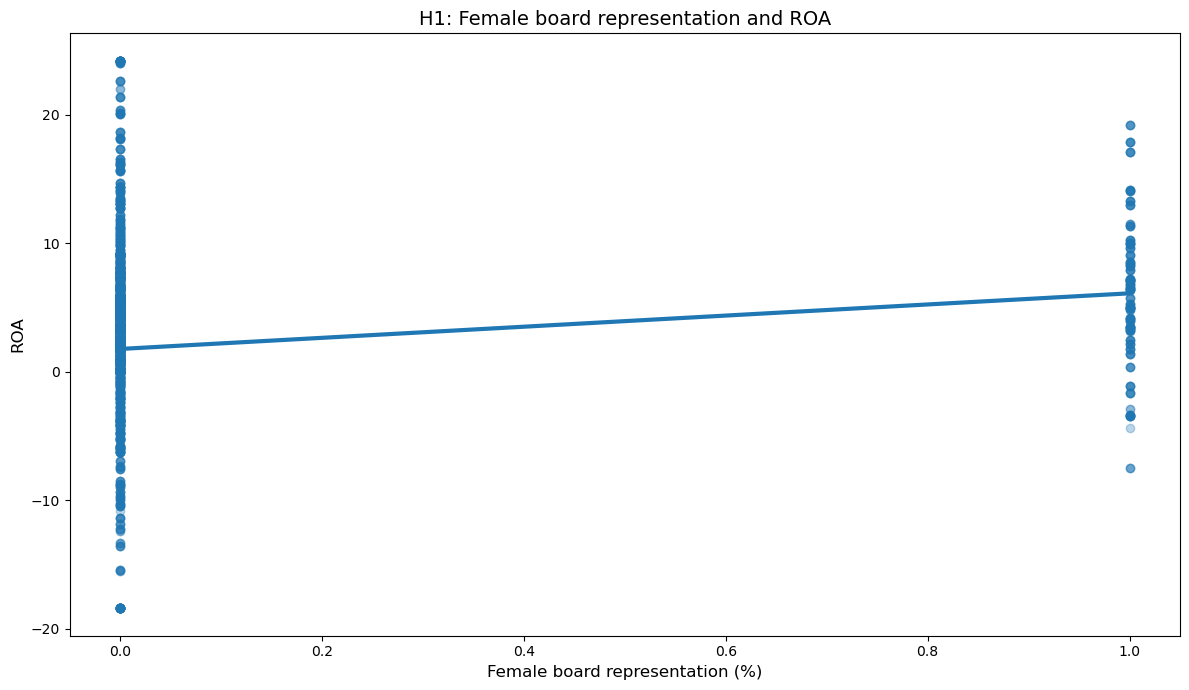

C:\Users\Dell\AppData\Local\Temp\ipykernel_1088\2043791472.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = dplot.groupby("Female_bin")[DV_H1].mean()


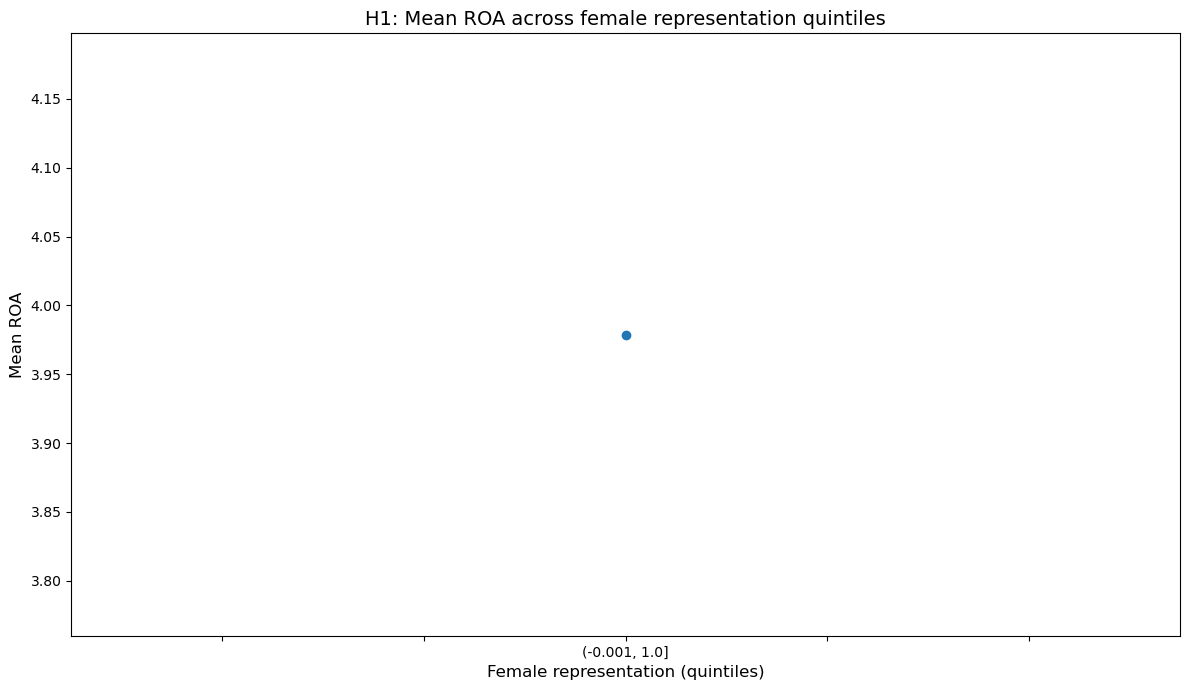

In [29]:
dplot = df.reset_index().copy()

# (1) Scatter + LOWESS: Female_pct vs ROA
plt.figure(figsize=(12, 7))
plt.scatter(dplot["Female_pct"], dplot[DV_H1], alpha=0.3)

lowess = sm.nonparametric.lowess(
    dplot[DV_H1],
    dplot["Female_pct"],
    frac=0.3
)

plt.plot(lowess[:,0], lowess[:,1], linewidth=3)
plt.xlabel("Female board representation (%)", fontsize=12)
plt.ylabel("ROA", fontsize=12)
plt.title("H1: Female board representation and ROA", fontsize=14)
plt.tight_layout()
plt.show()

# (2) Quintile mean ROA
dplot["Female_bin"] = pd.qcut(dplot["Female_pct"], 5, duplicates="drop")
means = dplot.groupby("Female_bin")[DV_H1].mean()

plt.figure(figsize=(12, 7))
means.plot(marker="o", linewidth=3)
plt.xlabel("Female representation (quintiles)", fontsize=12)
plt.ylabel("Mean ROA", fontsize=12)
plt.title("H1: Mean ROA across female representation quintiles", fontsize=14)
plt.tight_layout()
plt.show()


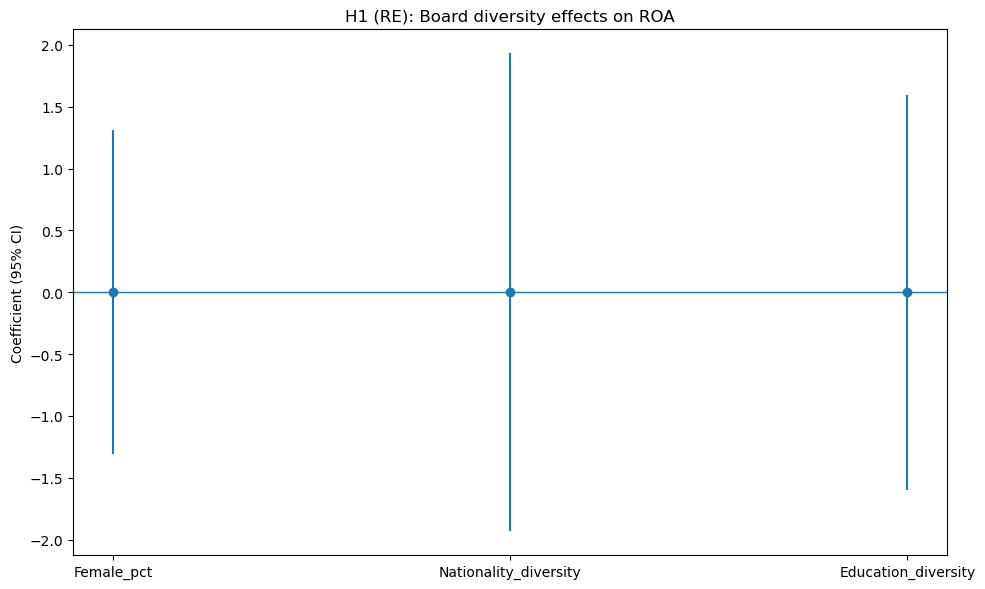

In [30]:
coef_plot(
    h1_re,
    "H1 (RE): Board diversity effects on ROA"
)


### The above figure presents coefficient estimates from the random-effects model for H1. All board diversity measures exhibit coefficients close to zero with wide confidence intervals that include zero, indicating no statistically significant association between board diversity and accounting performance.

In [31]:
DV_H2 = "Tobins_Q"

h2_re, n2 = run_re_only(DV_H2, df, IVS, controls_model)

print("\n=========================")
print("H2 (RE): Diversity → Tobin’s Q")
print("=========================")
print("N used:", n2)
print(h2_re.summary.as_text())



H2 (RE): Diversity → Tobin’s Q
N used: 2238
                        RandomEffects Estimation Summary                        
Dep. Variable:               Tobins_Q   R-squared:                        1.0000
Estimator:              RandomEffects   R-squared (Between):              1.0000
No. Observations:                2238   R-squared (Within):               0.9999
Date:                Sun, Dec 14 2025   R-squared (Overall):              1.0000
Time:                        22:03:11   Log-likelihood                 1.361e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   5.044e+06
Entities:                         503   P-value                           0.0000
Avg Obs:                       4.4493   Distribution:                 F(10,2227)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):   

C:\Users\Dell\anaconda\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


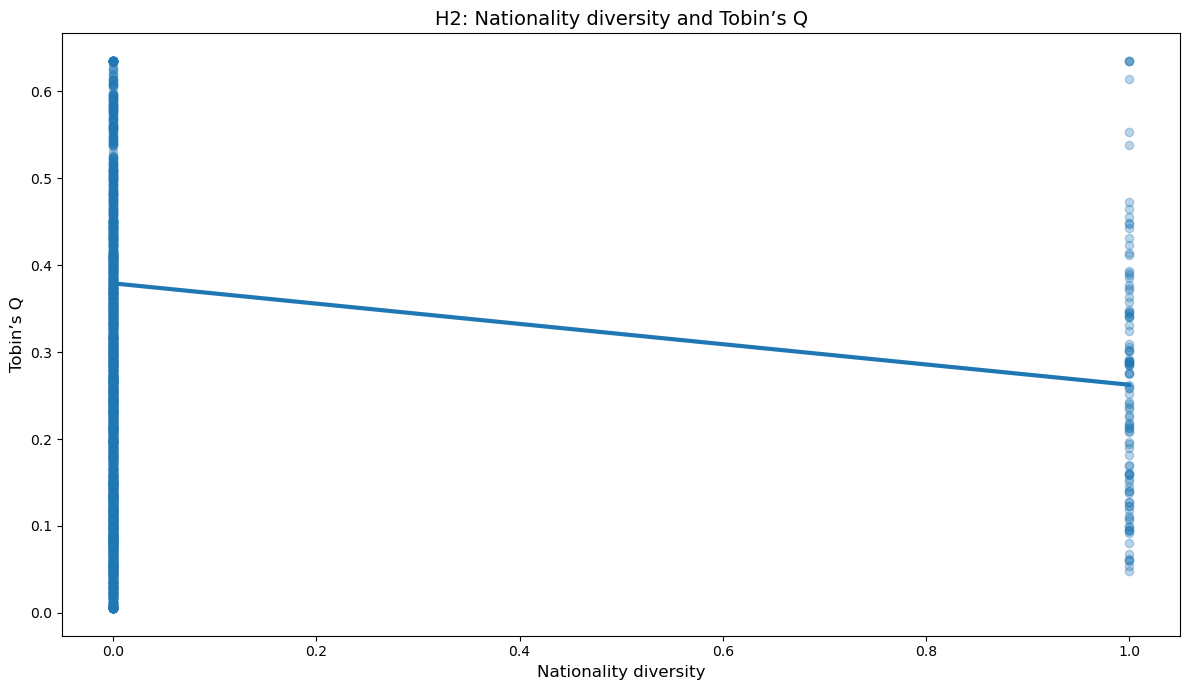

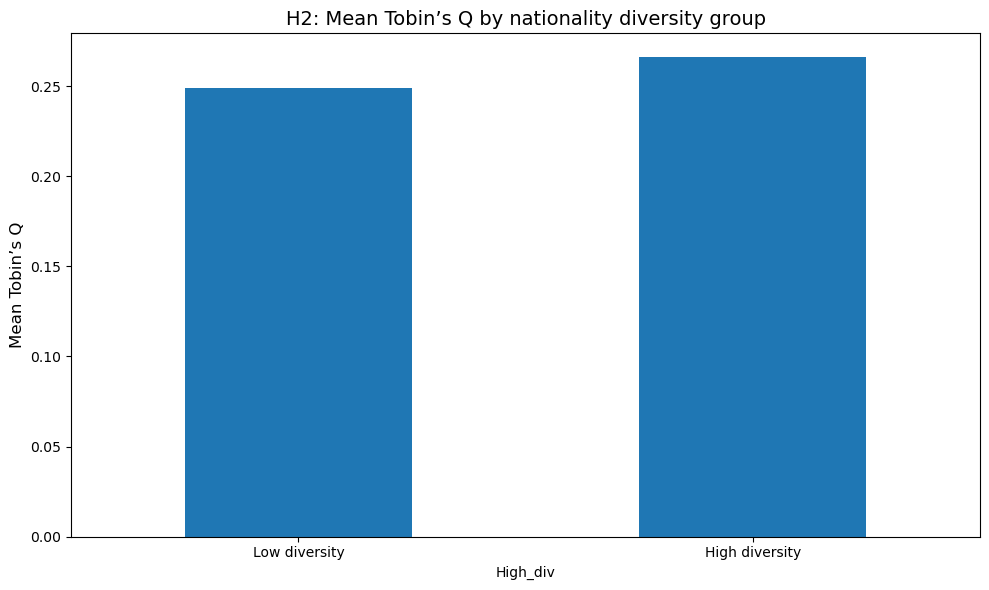

In [32]:
dplot = df.reset_index().copy()

# (1) Scatter + LOWESS: Nationality_diversity vs Tobin's Q
plt.figure(figsize=(12, 7))
plt.scatter(dplot["Nationality_diversity"], dplot[DV_H2], alpha=0.3)

lowess = sm.nonparametric.lowess(
    dplot[DV_H2],
    dplot["Nationality_diversity"],
    frac=0.3
)

plt.plot(lowess[:,0], lowess[:,1], linewidth=3)
plt.xlabel("Nationality diversity", fontsize=12)
plt.ylabel("Tobin’s Q", fontsize=12)
plt.title("H2: Nationality diversity and Tobin’s Q", fontsize=14)
plt.tight_layout()
plt.show()

# (2) High vs low diversity (median split)
median_div = dplot["Nationality_diversity"].median()
dplot["High_div"] = dplot["Nationality_diversity"] > median_div
means = dplot.groupby("High_div")[DV_H2].mean()

plt.figure(figsize=(10, 6))
means.plot(kind="bar")
plt.xticks([0, 1], ["Low diversity", "High diversity"], rotation=0)
plt.ylabel("Mean Tobin’s Q", fontsize=12)
plt.title("H2: Mean Tobin’s Q by nationality diversity group", fontsize=14)
plt.tight_layout()
plt.show()


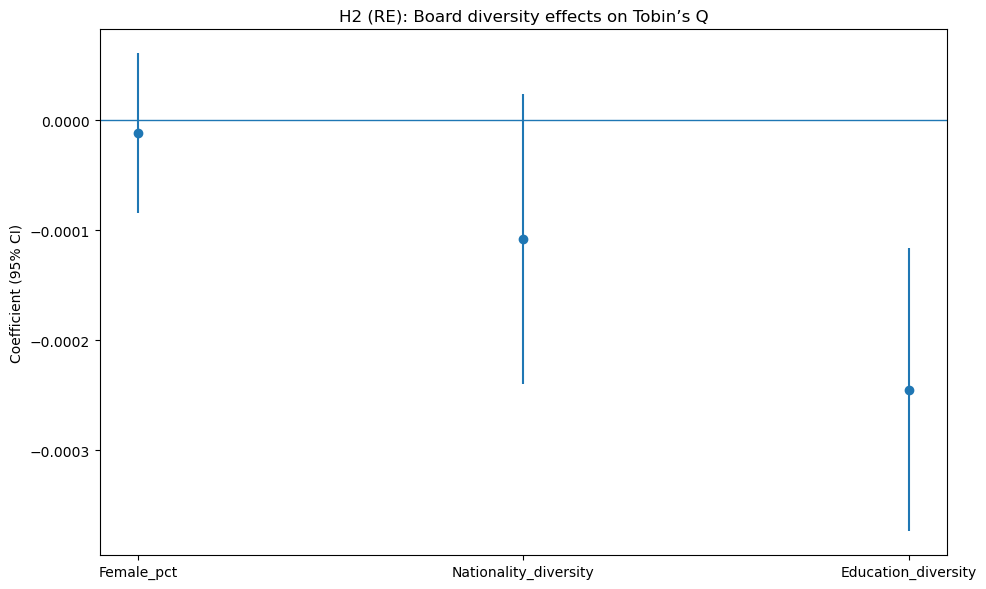

In [33]:
coef_plot(h2_re, "H2 (RE): Board diversity effects on Tobin’s Q")

In [34]:
DV_H3 = "ln_Publication_Count"  # must exist in df

h3_re, n3 = run_re_only(DV_H3, df, IVS, controls_model)

print("\n====================================")
print("H3 (RE): Diversity → Innovation (log pubs)")
print("====================================")
print("N used:", n3)
print(h3_re.summary.as_text())



H3 (RE): Diversity → Innovation (log pubs)
N used: 2238
                         RandomEffects Estimation Summary                         
Dep. Variable:     ln_Publication_Count   R-squared:                        0.1235
Estimator:                RandomEffects   R-squared (Between):              0.3939
No. Observations:                  2238   R-squared (Within):            -5.51e-07
Date:                  Sun, Dec 14 2025   R-squared (Overall):              0.4128
Time:                          22:03:12   Log-likelihood                    2941.2
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      31.387
Entities:                           503   P-value                           0.0000
Avg Obs:                         4.4493   Distribution:                 F(10,2227)
Min Obs:                         1.0000                                           
Max Obs:                      

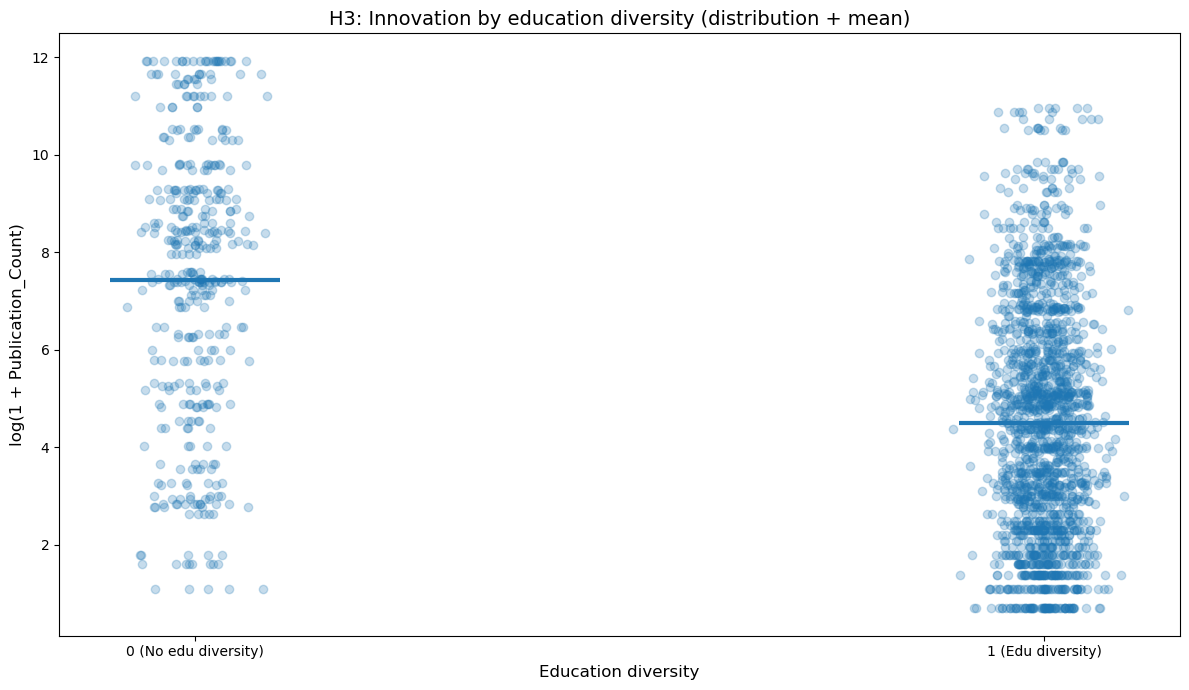

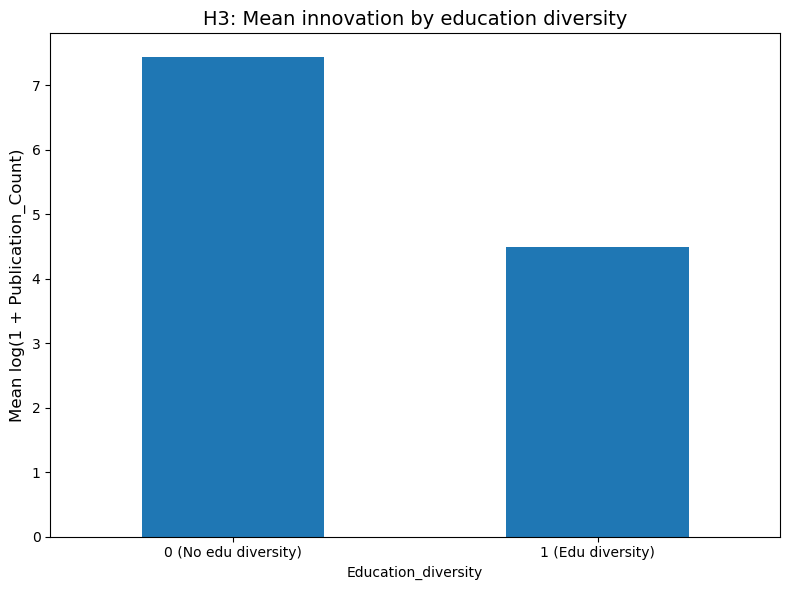

In [35]:
dplot = df.reset_index().copy()

# add slight jitter so points at 0 and 1 don't overlap perfectly
x = dplot["Education_diversity"] + np.random.normal(0, 0.03, size=len(dplot))

plt.figure(figsize=(12, 7))
plt.scatter(x, dplot[DV_H3], alpha=0.25)

# group means
m0 = dplot.loc[dplot["Education_diversity"] == 0, DV_H3].mean()
m1 = dplot.loc[dplot["Education_diversity"] == 1, DV_H3].mean()

plt.hlines(m0, -0.1, 0.1, linewidth=3)
plt.hlines(m1,  0.9, 1.1, linewidth=3)

plt.xticks([0, 1], ["0 (No edu diversity)", "1 (Edu diversity)"])
plt.xlabel("Education diversity", fontsize=12)
plt.ylabel("log(1 + Publication_Count)", fontsize=12)
plt.title("H3: Innovation by education diversity (distribution + mean)", fontsize=14)
plt.tight_layout()
plt.show()


means = dplot.groupby("Education_diversity")[DV_H3].mean()

plt.figure(figsize=(8, 6))
means.plot(kind="bar")
plt.xticks([0, 1], ["0 (No edu diversity)", "1 (Edu diversity)"], rotation=0)
plt.ylabel("Mean log(1 + Publication_Count)", fontsize=12)
plt.title("H3: Mean innovation by education diversity", fontsize=14)
plt.tight_layout()
plt.show()


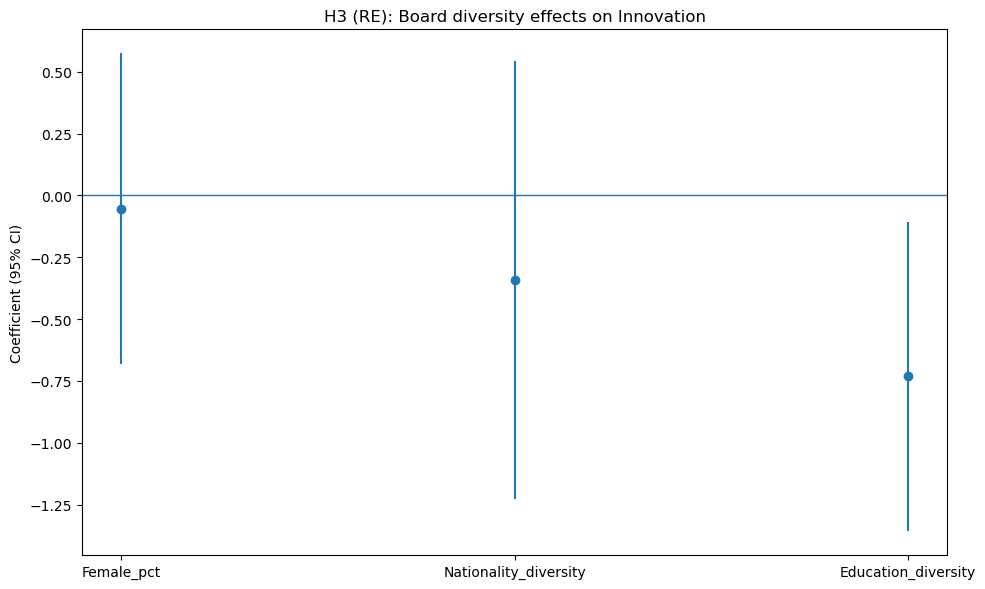

In [36]:
coef_plot(h3_re, "H3 (RE): Board diversity effects on Innovation")

In [37]:
def extract_coef_pval(res, IVS):
    coefs = res.params[IVS]
    pvals = res.pvalues[IVS]
    return [f"{c:.4f} ({p:.3f})" for c, p in zip(coefs, pvals)]


table_main = pd.DataFrame({
    "H1: ROA (RE)": extract_coef_pval(h1_re, IVS),
    "H2: Tobin’s Q (RE)": extract_coef_pval(h2_re, IVS),
    "H3: Innovation (RE)": extract_coef_pval(h3_re, IVS)
}, index=IVS)

display(table_main)


,H1: ROA (RE),H2: Tobin’s Q (RE),H3: Innovation (RE)
Female_pct,0.0002 (1.000),-0.0000 (0.753),-0.0542 (0.866)
Nationality_diversity,0.0001 (1.000),-0.0001 (0.107),-0.3413 (0.450)
Education_diversity,0.0005 (0.999),-0.0002 (0.000),-0.7318 (0.022)


In [38]:
d = df.reset_index().copy()

rhs = " + ".join(IVS + controls_model)

fe_terms = []
if "Year" in d.columns:
    fe_terms.append("C(Year)")
if "NACE_raw" in d.columns:
    fe_terms.append("C(NACE_raw)")

fe_str = " + ".join(fe_terms)

formula_h1 = f"ROA_using_Net_income ~ {rhs}" + (f" + {fe_str}" if fe_str else "")

In [39]:
formula_h1 = f"ROA_using_Net_income ~ {rhs}" + (f" + {fe_str}" if fe_str else "")
ols_h1 = smf.ols(formula_h1, data=d).fit(
    cov_type="cluster",
    cov_kwds={"groups": d["firm_id"]}
)

print(ols_h1.summary())


                             OLS Regression Results                             
Dep. Variable:     ROA_using_Net_income   R-squared:                       0.742
Model:                              OLS   Adj. R-squared:                  0.736
Method:                   Least Squares   F-statistic:                     37.20
Date:                  Sun, 14 Dec 2025   Prob (F-statistic):          9.84e-133
Time:                          22:03:13   Log-Likelihood:                -5899.3
No. Observations:                  2238   AIC:                         1.190e+04
Df Residuals:                      2185   BIC:                         1.221e+04
Df Model:                            52                                         
Covariance Type:                cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

C:\Users\Dell\anaconda\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 52, but rank is 46
  warnings.warn('covariance of constraints does not have full '


In [40]:
formula_h2 = f"Tobins_Q ~ {rhs}" + (f" + {fe_str}" if fe_str else "")
ols_h2 = smf.ols(formula_h2, data=d).fit(
    cov_type="cluster",
    cov_kwds={"groups": d["firm_id"]}
)

print("\nROBUSTNESS OLS (H2: Tobin’s Q) — firm clustered")
print(ols_h2.summary())



ROBUSTNESS OLS (H2: Tobin’s Q) — firm clustered
                            OLS Regression Results                            
Dep. Variable:               Tobins_Q   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.862e+07
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:03:14   Log-Likelihood:                 13004.
No. Observations:                2238   AIC:                        -2.590e+04
Df Residuals:                    2185   BIC:                        -2.560e+04
Df Model:                          52                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

C:\Users\Dell\anaconda\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 52, but rank is 46
  warnings.warn('covariance of constraints does not have full '


In [41]:
formula_h3 = f"ln_Publication_Count ~ {rhs}" + (f" + {fe_str}" if fe_str else "")
ols_h3 = smf.ols(formula_h3, data=d).fit(
    cov_type="cluster",
    cov_kwds={"groups": d["firm_id"]}
)

print("\nROBUSTNESS OLS (H3: Innovation) — firm clustered")
print(ols_h3.summary())



ROBUSTNESS OLS (H3: Innovation) — firm clustered
                             OLS Regression Results                             
Dep. Variable:     ln_Publication_Count   R-squared:                       0.595
Model:                              OLS   Adj. R-squared:                  0.585
Method:                   Least Squares   F-statistic:                     68.61
Date:                  Sun, 14 Dec 2025   Prob (F-statistic):          1.82e-186
Time:                          22:03:14   Log-Likelihood:                -4402.8
No. Observations:                  2238   AIC:                             8912.
Df Residuals:                      2185   BIC:                             9214.
Df Model:                            52                                         
Covariance Type:                cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

C:\Users\Dell\anaconda\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 52, but rank is 46
  warnings.warn('covariance of constraints does not have full '


In [42]:
def extract_coef_pval_sm(res, IVS):
    coefs = [res.params[v] for v in IVS]
    pvals = [res.pvalues[v] for v in IVS]
    return [f"{c:.4f} ({p:.3f})" for c, p in zip(coefs, pvals)]

table_robust = pd.DataFrame({
    "H1: ROA (OLS+FE)": extract_coef_pval_sm(ols_h1, IVS),
    "H2: Tobin’s Q (OLS+FE)": extract_coef_pval_sm(ols_h2, IVS),
    "H3: Innovation (OLS+FE)": extract_coef_pval_sm(ols_h3, IVS),
}, index=IVS)

display(table_robust)


,H1: ROA (OLS+FE),H2: Tobin’s Q (OLS+FE),H3: Innovation (OLS+FE)
Female_pct,0.8670 (0.065),0.0000 (0.742),0.0880 (0.759)
Nationality_diversity,-0.9886 (0.217),-0.0001 (0.279),-0.3714 (0.396)
Education_diversity,0.1919 (0.717),-0.0002 (0.002),-0.5883 (0.024)


In [43]:
# Ensure same row order
table_main = table_main.reindex(IVS)
table_robust = table_robust.reindex(IVS)

merged = pd.concat(
    {
        "Main (RE)": table_main,
        "Robustness (OLS+FE)": table_robust
    },
    axis=1
)

display(merged)


Main (RE)                                         \
                         H1: ROA (RE) H2: Tobin’s Q (RE) H3: Innovation (RE)   
Female_pct             0.0002 (1.000)    -0.0000 (0.753)     -0.0542 (0.866)   
Nationality_diversity  0.0001 (1.000)    -0.0001 (0.107)     -0.3413 (0.450)   
Education_diversity    0.0005 (0.999)    -0.0002 (0.000)     -0.7318 (0.022)   

                      Robustness (OLS+FE)                         \
                         H1: ROA (OLS+FE) H2: Tobin’s Q (OLS+FE)   
Female_pct                 0.8670 (0.065)         0.0000 (0.742)   
Nationality_diversity     -0.9886 (0.217)        -0.0001 (0.279)   
Education_diversity        0.1919 (0.717)        -0.0002 (0.002)   

                                               
                      H3: Innovation (OLS+FE)  
Female_pct                     0.0880 (0.759)  
Nationality_diversity         -0.3714 (0.396)  
Education_diversity           -0.5883 (0.024)

### As a robustness check, pooled OLS models including year and industry fixed effects were estimated with standard errors clustered at the firm level. While the direction and significance of some coefficients differ from the random-effects results, this is expected given that random-effects models exploit both within- and between-firm variation, whereas pooled OLS with fixed effects relies primarily on within-firm variation and dummy-variable adjustment. Given the absence of within-firm variation in board diversity measures, two-way fixed-effects models absorb the key independent variables, making random-effects the preferred specification. Accordingly, the main inferences are drawn from the random-effects estimates, with the robustness results indicating sensitivity rather than contradiction.